# Run Loop Algorithm & View Example Scenario

In [5]:
# load in the pyloopkit repository
! git clone https://github.com/tidepool-org/PyLoopKit

Cloning into 'PyLoopKit'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 1592 (delta 4), reused 9 (delta 1), pack-reused 1580
Receiving objects: 100% (1592/1592), 3.10 MiB | 4.10 MiB/s, done.
Resolving deltas: 100% (1018/1018), done.


In [226]:
# load in required libraries and functions
import datetime
import os
import sys
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# load in pyloop modules (functions)
pyLoop_path = os.path.abspath(os.path.join(".", "PyLoopKit"))
sys.path.insert(0, pyLoop_path)
from pyloop_parser import parse_report_and_run
from loop_math import predict_glucose

# define functions
def convert_times_and_types(obj):
    """ Convert dose types into strings """
    return str(obj.name)

In [227]:
# run the loop algorithm using one of example files
example_file_name = "example_issue_report_1.json"
example_file_path = os.path.join(pyLoop_path, "example_files")
recommendations = parse_report_and_run(
    example_file_path, example_file_name
)
print("here is the output, which also includes the inputs:")
list(recommendations.keys())

here is the output, which also includes the inputs:


['predicted_glucose_dates',
 'predicted_glucose_values',
 'recommended_temp_basal',
 'recommended_bolus',
 'insulin_effect_dates',
 'insulin_effect_values',
 'counteraction_effect_start_times',
 'counteraction_effect_end_times',
 'counteraction_effect_values',
 'momentum_effect_dates',
 'momentum_effect_values',
 'carb_effect_dates',
 'carb_effect_values',
 'retrospective_effect_dates',
 'retrospective_effect_values',
 'carbs_on_board',
 'cob_timeline_dates',
 'cob_timeline_values',
 'input_data']

# Get data into format for visualization

In [228]:
# get input data from output file
inputs = recommendations.get("input_data")
print("here is the input data list")
list(inputs.keys())

here is the input data list


['offset_applied_to_dates',
 'time_to_calculate_at',
 'glucose_dates',
 'glucose_values',
 'glucose_units',
 'dose_types',
 'dose_start_times',
 'dose_end_times',
 'dose_values',
 'dose_value_units',
 'carb_dates',
 'carb_values',
 'carb_absorption_times',
 'carb_value_units',
 'settings_dictionary',
 'sensitivity_ratio_start_times',
 'sensitivity_ratio_end_times',
 'sensitivity_ratio_values',
 'sensitivity_ratio_value_units',
 'carb_ratio_start_times',
 'carb_ratio_values',
 'carb_ratio_value_units',
 'basal_rate_start_times',
 'basal_rate_minutes',
 'basal_rate_values',
 'basal_rate_units',
 'target_range_start_times',
 'target_range_end_times',
 'target_range_minimum_values',
 'target_range_maximum_values',
 'target_range_value_units',
 'last_temporary_basal']

In [229]:
# general inputs
current_time = inputs.get("time_to_calculate_at")
current_time

datetime.datetime(2019, 7, 26, 15, 13, 17, tzinfo=datetime.timezone.utc)

# Blood Glucose (BG) Data

In [230]:
# blood glucose data
glucose_dates = pd.DataFrame(inputs.get("glucose_dates"), columns=["time"])
glucose_values = pd.DataFrame(inputs.get("glucose_values"), columns=["mg_dL"])
bg = pd.concat([glucose_dates, glucose_values], axis=1)
bg.head()

,time,mg_dL
0,2019-07-25 16:12:46+00:00,167.566
1,2019-07-25 16:17:46+00:00,163.652
2,2019-07-25 16:22:46+00:00,167.946
3,2019-07-25 16:27:46+00:00,172.881
4,2019-07-25 16:32:46+00:00,171.076


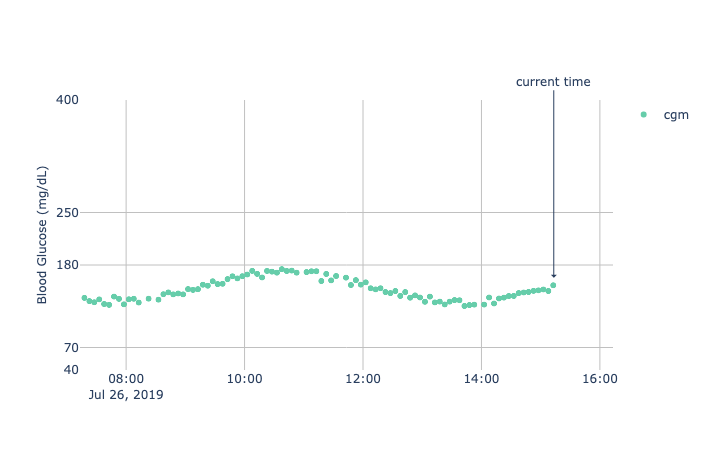

In [248]:
# view BG inputs
# Set bg color values
bg['bg_colors'] = 'mediumaquamarine'
bg.loc[bg['mg_dL'] < 54, 'bg_colors'] = 'indianred'
low_location = (bg['mg_dL'] > 54) & (bg['mg_dL'] < 70)
bg.loc[low_location, 'bg_colors'] = 'lightcoral'
high_location = (bg['mg_dL'] > 180) & (bg['mg_dL'] <= 250)
bg.loc[high_location, 'bg_colors'] = 'mediumpurple'
bg.loc[(bg['mg_dL'] > 250), 'bg_colors'] = 'slateblue'

bg_trace = go.Scattergl(
    name="cgm",
    x=bg["time"],
    y=bg["mg_dL"],
    hoverinfo="y+name",
    hoverlabel=dict(
        bgcolor=bg["bg_colors"]
    ),
    mode='markers',
    marker=dict(
        size=6,
        line=dict(width=0),
        color=bg["bg_colors"]
    )
)

layout = go.Layout(
    showlegend=True,
    plot_bgcolor="white",
    yaxis=dict(
        range=[40, 400],
        tickvals=[-100, 40, 70, 180, 250, 400],
        fixedrange=True,
        hoverformat=".0f",
        zeroline=False,
        showgrid=True,
        gridcolor="#c0c0c0",
        title=dict(
            text="Blood Glucose (mg/dL)",
            font=dict(
                size=12
            )
        )
    ),
    xaxis=dict(
        range=(
            current_time - datetime.timedelta(hours=8),
            current_time + datetime.timedelta(hours=1)
        ),
        showgrid=True,
        gridcolor="#c0c0c0",
    ),
    annotations=[
        go.layout.Annotation(
            x=current_time,
            y=bg["mg_dL"].values[-1] + 10,
            xref="x",
            yref="y",
            text="current time",
            showarrow=True,
            arrowhead=1,
            ax=0,
            ayref="y",
            ay=425
        )
    ],
    dragmode="pan",
    hovermode="x"
)

fig = go.Figure(data=bg_trace, layout=layout)
fig

# Insulin & Carb Event Data (bolus, basals, suspends, and carbs)

## Insulin (Dose) Data

In [232]:
 # insulin (dose) data
dose_start_times = (
    pd.DataFrame(inputs.get("dose_start_times"), columns=["startTime"])
)
dose_end_times = (
    pd.DataFrame(inputs.get("dose_end_times"), columns=["endTime"])
)
dose_values = (
    pd.DataFrame(inputs.get("dose_values"), columns=["dose"])
)
dose_types = (
    pd.DataFrame(inputs.get("dose_types"), columns=["type"])
)
dose_types["type"] = dose_types["type"].apply(convert_times_and_types)
dose = pd.concat(
    [dose_start_times, dose_end_times, dose_values, dose_types],
    axis=1
)

dose["duration"] = (dose["endTime"] - dose["startTime"]).dt.seconds
unique_dose_types = dose["type"].unique()
dose.head()

,startTime,endTime,dose,type,duration
0,2019-07-26 15:13:11+00:00,2019-07-26 15:15:11+00:00,3.0,bolus,120


### Bolus Data

In [233]:
# bolus data
if "bolus" in unique_dose_types:
    bolus = dose[dose["type"] == "bolus"]

bolus.head()

,startTime,endTime,dose,type,duration
0,2019-07-26 15:13:11+00:00,2019-07-26 15:15:11+00:00,3.0,bolus,120


### Basal Data (Scheduled & Temp Basal Rates)

In [234]:
# scheduled basal rate
basal_rate_start_times = (
    pd.DataFrame(inputs.get("basal_rate_start_times"), columns=["time"])
)
basal_rate_minutes = (
    pd.DataFrame(inputs.get("basal_rate_minutes"), columns=["duration"])
)
basal_rate_values = (
    pd.DataFrame(inputs.get("basal_rate_values"), columns=["sbr"])
)
sbr = pd.concat(
    [basal_rate_start_times, basal_rate_minutes, basal_rate_values],
    axis=1
)

# create a contiguous basal time series
bg_range = pd.date_range(
    bg["time"].min() - datetime.timedelta(days=1),
    current_time,
    freq="1s"
)
contig_ts = pd.DataFrame(bg_range, columns=["datetime"])
contig_ts["time"] = contig_ts["datetime"].dt.time
basal = pd.merge(contig_ts, sbr, on="time", how="left")
basal["sbr"].fillna(method='ffill', inplace=True)
basal.dropna(subset=['sbr'], inplace=True)

# temp basal data
if (("basal" in unique_dose_types) | ("suspend" in unique_dose_types)):
    temp_basal = (
        dose[((dose["type"] == "basal") | (dose["type"] == "suspend"))]
    )

    temp_basal["type"].replace("basal", "temp", inplace=True)
    all_temps = pd.DataFrame()
    for idx in temp_basal.index:
        rng = pd.date_range(
            temp_basal.loc[idx, "startTime"],
            temp_basal.loc[idx, "endTime"] - datetime.timedelta(seconds=1),
            freq="1s"
        )
        temp_ts = pd.DataFrame(rng, columns=["datetime"])
        temp_ts["tbr"] = temp_basal.loc[idx, "dose"]
        temp_ts["type"] = temp_basal.loc[idx, "type"]
        all_temps = pd.concat([all_temps, temp_ts])

    basal = pd.merge(basal, all_temps, on="datetime", how="left")
    basal["type"].fillna("scheduled", inplace=True)

else:
    basal["tbr"] = np.nan

basal["delivered"] = basal["tbr"]
basal.loc[basal["delivered"].isnull(), "delivered"] = (
    basal.loc[basal["delivered"].isnull(), "sbr"]
)

# downsample basal
basal_range = pd.date_range(
    basal["datetime"].min(),
    current_time,
    freq="5min"
)
basal_ts = pd.DataFrame(basal_range, columns=["datetime"])
basal = pd.merge(basal_ts, basal, on="datetime", how="left")
# add back in the current time
last_index = basal.index.max()
basal.loc[last_index + 1, "datetime"] = current_time
basal.loc[last_index + 1, "sbr"] = basal.loc[last_index, "sbr"]
basal.loc[last_index + 1, "tbr"] = basal.loc[last_index, "tbr"]
basal.loc[last_index + 1, "delivered"] = basal.loc[last_index, "delivered"]
basal.head()

,datetime,time,duration,sbr,tbr,delivered
0,2019-07-24 21:00:00+00:00,21:00:00,1260.0,0.75,NaN,0.75
1,2019-07-24 21:05:00+00:00,21:05:00,NaN,0.75,NaN,0.75
2,2019-07-24 21:10:00+00:00,21:10:00,NaN,0.75,NaN,0.75
3,2019-07-24 21:15:00+00:00,21:15:00,NaN,0.75,NaN,0.75
4,2019-07-24 21:20:00+00:00,21:20:00,NaN,0.75,NaN,0.75


## Carb Data (CIR and Carb Events)

In [235]:
# carb-to-insulin-ratio
carb_ratio_start_times = (
    pd.DataFrame(inputs.get("carb_ratio_start_times"), columns=["time"])
)
carb_ratio_values = (
    pd.DataFrame(inputs.get("carb_ratio_values"), columns=["cir"])
)
cir = pd.concat([carb_ratio_start_times, carb_ratio_values], axis=1)

carbs = pd.merge(contig_ts, cir, on="time", how="left")
carbs["cir"].fillna(method='ffill', inplace=True)
carbs.dropna(subset=['cir'], inplace=True)

# carb events
carb_dates = pd.DataFrame(inputs.get("carb_dates"), columns=["datetime"])
carb_values = pd.DataFrame(inputs.get("carb_values"), columns=["grams"])
carb_absorption_times = (
    pd.DataFrame(
        inputs.get("carb_absorption_times"),
        columns=["aborption_time"]
    )
)
carb_events = (
    pd.concat([carb_dates, carb_values, carb_absorption_times], axis=1)
)

carbs = pd.merge(carbs, carb_events, on="datetime", how="left")

# add bolus height for figure
carbs["bolus_height"] = carbs["grams"] / carbs["cir"]

# TODO: visualize the carb-to-insulin-ratio (cir)
# in the meantime drop rows where grams is null
carbs.dropna(subset=['grams'], inplace=True)
carbs.head()

,datetime,time,cir,grams,aborption_time,bolus_height
168181,2019-07-26 15:13:01+00:00,15:13:01,12.0,40.0,240.0,3.333333


# Visualize Insulin & Carb Event Data

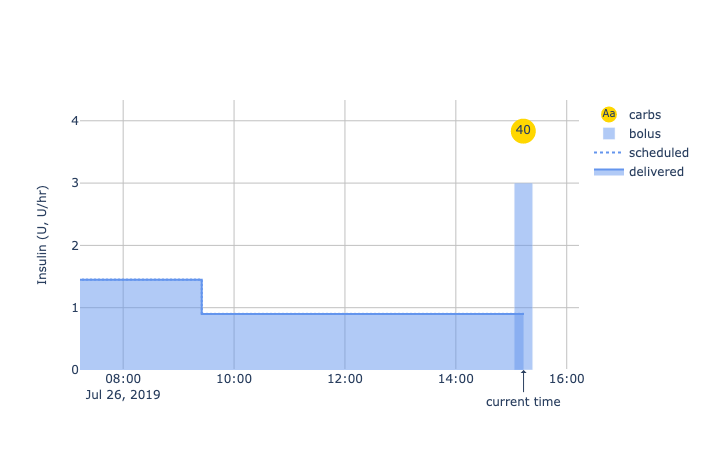

In [236]:
bolus_trace = go.Bar(
    name="bolus",
    x=bolus["startTime"],
    y=bolus["dose"],
    hoverinfo="y+name",
    width=2000*60*10,
    marker=dict(color='cornflowerblue'),
    opacity=0.5
)

sbr_trace = go.Scattergl(
    name="scheduled",
    mode='lines',
    x=basal["datetime"],
    y=basal["sbr"],
    hoverinfo="y+name",
    line=dict(
        shape='vh',
        color='cornflowerblue',
        dash='dot'
    )
)

basal_trace = go.Scatter(
    name="delivered",
    mode='lines',
    x=basal["datetime"],
    y=basal["delivered"],
    hoverinfo="y+name",
    line=dict(
        shape='vh',
        color='cornflowerblue'
    ),
    fill='tonexty'
)

carb_trace = go.Scatter(
    name="carbs",
    mode='markers + text',
    x=carbs["datetime"],
    y=carbs["bolus_height"] + 0.5,
    hoverinfo="name",
    marker=dict(
        color='gold',
        size=25
    ),
    text=carbs["grams"],
    textposition='middle center'
)
data = [
    basal_trace, sbr_trace,
    bolus_trace, carb_trace,
]

y_height = max(
    basal["sbr"].max(),
    basal["tbr"].max(),
    bolus["dose"].max(),
    carbs["bolus_height"].max()
) + 1

layout = go.Layout(
    showlegend=True,
    plot_bgcolor="white",
    yaxis=dict(
        range=[0, y_height],
        fixedrange=True,
        hoverformat=".2f",
        showgrid=True,
        gridcolor="#c0c0c0",
        title=dict(
            text="Insulin (U, U/hr)",
            font=dict(
                size=12
            )
        )
    ),
    xaxis=dict(
        range=(
            current_time - datetime.timedelta(hours=8),
            current_time + datetime.timedelta(hours=1)
        ),
        showgrid=True,
        gridcolor="#c0c0c0",
    ),
    annotations=[
        go.layout.Annotation(
            x=current_time,
            y=0,
            xref="x",
            yref="y",
            text="current time",
            showarrow=True,
            arrowhead=1,
            ax=0,
            ayref="y",
            ay=-0.5
        )
    ],
    dragmode="pan",
    hovermode="x"
)

# TODO: put basal and bolus amounts on the same scale
# so that the amount of insulin is represented by the area
# of the bars
fig = go.Figure(data=data, layout=layout)
fig

# Visualize Recommended Temp Basal (and Bolus)

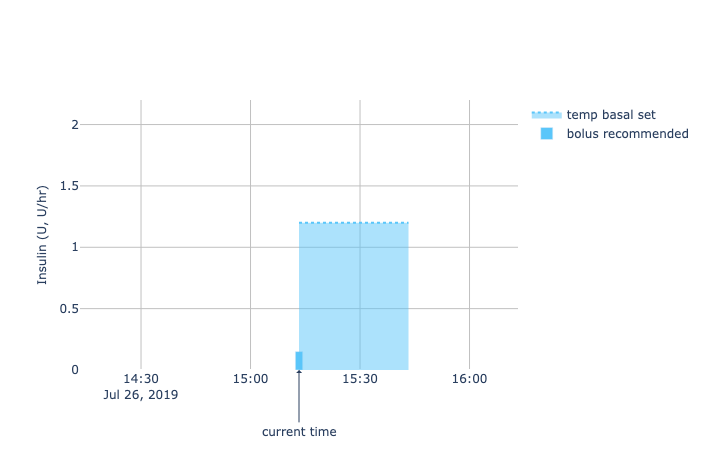

In [246]:
# recommended temp basal
recommended_temp_basal = recommendations.get("recommended_temp_basal")
if recommended_temp_basal is not None:
    rec_temp_basal_rate = recommended_temp_basal[0]
    rec_temp_basal_duration = recommended_temp_basal[1]
else:
    rec_temp_basal_rate = basal.loc[basal.index.max(), "sbr"]
    rec_temp_basal_duration = 30

recommended_basal_trace = go.Scatter(
    name="temp basal set",
    mode='lines',
    x=[
       current_time,
       current_time + datetime.timedelta(minutes=rec_temp_basal_duration),
    ],
    y=[rec_temp_basal_rate, rec_temp_basal_rate],
    hoverinfo="y+name",
    line=dict(
        shape='vh',
        color='#5ac6fa',
        dash='dot'
    ),
    fill='tozeroy'
)

# recommended bolus
recommended_bolus = recommendations.get("recommended_bolus")[0]

recommended_bolus_trace = go.Bar(
    name="bolus recommended",
    x=[current_time],
    y=[recommended_bolus],
    hoverinfo="y+name",
    width=2000*60,
    marker=dict(color='#5ac6fa')
)

y_rec_height = max(
    recommended_bolus,
    rec_temp_basal_rate,
) + 1

layout = go.Layout(
    showlegend=True,
    plot_bgcolor="white",
    yaxis=dict(
        range=[0, y_rec_height],
        fixedrange=True,
        hoverformat=".2f",
        showgrid=True,
        gridcolor="#c0c0c0",
        title=dict(
            text="Insulin (U, U/hr)",
            font=dict(
                size=12
            )
        )
    ),
    xaxis=dict(
        range=(
            current_time - datetime.timedelta(hours=1),
            current_time + datetime.timedelta(hours=1)
        ),
        showgrid=True,
        gridcolor="#c0c0c0",
    ),
    annotations=[
        go.layout.Annotation(
            x=current_time,
            y=0,
            xref="x",
            yref="y",
            text="current time",
            showarrow=True,
            arrowhead=1,
            ax=0,
            ayref="y",
            ay=-0.5
        )
    ],
    dragmode="pan",
    hovermode="x"
)
data = [recommended_basal_trace, recommended_bolus_trace]
fig = go.Figure(data=data, layout=layout)
fig

# Loop BG Prediction

## Overall Prediction

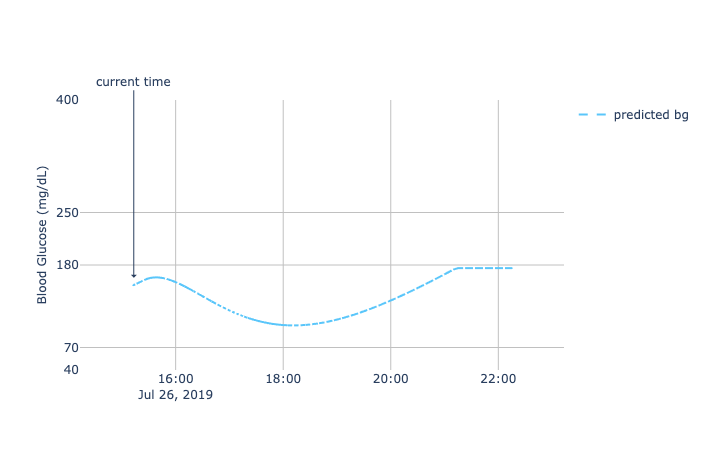

In [247]:
# get overall prediction
overall_predicted_glucose_dates = recommendations.get("predicted_glucose_dates")
overall_predicted_glucose_values = recommendations.get("predicted_glucose_values")

# overall prediction
bg_prediction_trace = go.Scattergl(
    name="predicted bg",
    x=overall_predicted_glucose_dates,
    y=overall_predicted_glucose_values,
    hoverinfo="y+name",
    mode='lines',
    line=dict(
        color="#5ac6fa",
        dash="dash",
    )
)
layout = go.Layout(
    showlegend=True,
    plot_bgcolor="white",
    yaxis=dict(
        range=[40, 400],
        tickvals=[-100, 40, 70, 180, 250, 400],
        fixedrange=True,
        hoverformat=".0f",
        zeroline=False,
        showgrid=True,
        gridcolor="#c0c0c0",
        title=dict(
            text="Blood Glucose (mg/dL)",
            font=dict(
                size=12
            )
        )
    ),
    xaxis=dict(
        range=(
            current_time - datetime.timedelta(hours=1),
            current_time + datetime.timedelta(hours=8)
        ),
        showgrid=True,
        gridcolor="#c0c0c0",
    ),
    annotations=[
        go.layout.Annotation(
            x=current_time,
            y=bg["mg_dL"].values[-1] + 10,
            xref="x",
            yref="y",
            text="current time",
            showarrow=True,
            arrowhead=1,
            ax=0,
            ayref="y",
            ay=425
        )
    ],
    dragmode="pan",
    hovermode="x"
)

fig = go.Figure(data=[bg_prediction_trace], layout=layout)
fig

In [239]:
# get separate glucose predictions using each effect individually
starting_date = recommendations.get("input_data").get("glucose_dates")[-1]
starting_glucose = recommendations.get("input_data").get("glucose_values")[-1]

## Insulin Effect

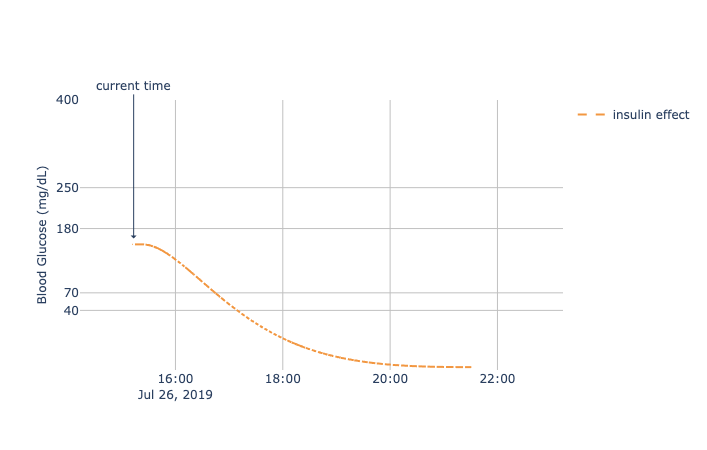

In [240]:
insulin_predicted_glucose_dates, insulin_predicted_glucose_values = predict_glucose(
     starting_date, starting_glucose,
     insulin_effect_dates=recommendations.get("insulin_effect_dates"),
     insulin_effect_values=recommendations.get("insulin_effect_values")
)

insulin_effect_trace = go.Scattergl(
    name="insulin effect",
    x=insulin_predicted_glucose_dates,
    y=insulin_predicted_glucose_values,
    hoverinfo="y+name",
    mode='lines',
    line=dict(
        color="#f29741",
        dash="dash",
    )
)

fig = go.Figure(data=[insulin_effect_trace], layout=layout)
fig.update_layout(yaxis=dict(range=[
    min(0, min(insulin_predicted_glucose_values)-5),
    max(400, max(insulin_predicted_glucose_values)+5)
]))

fig

## Carb Effect

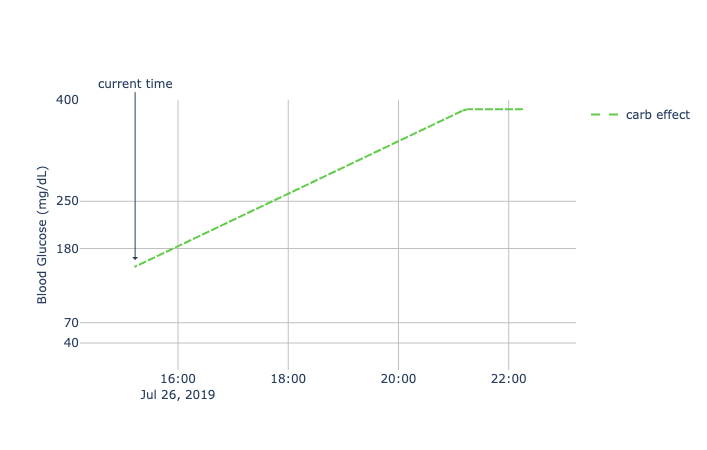

In [241]:
carb_predicted_glucose_dates, carb_predicted_glucose_values = predict_glucose(
    starting_date,
    starting_glucose,
    carb_effect_dates=recommendations.get("carb_effect_dates"),
    carb_effect_values=recommendations.get("carb_effect_values")
)

carb_effect_trace = go.Scattergl(
    name="carb effect",
    x=carb_predicted_glucose_dates,
    y=carb_predicted_glucose_values,
    hoverinfo="y+name",
    mode='lines',
    line=dict(
        color="#5FCB49",
        dash="dash",
    )
)

fig = go.Figure(data=[carb_effect_trace], layout=layout)
fig.update_layout(yaxis=dict(range=[
    min(0, min(carb_predicted_glucose_values)-5),
    max(400, max(carb_predicted_glucose_values)+5)
]))
fig

## Momentum Effect

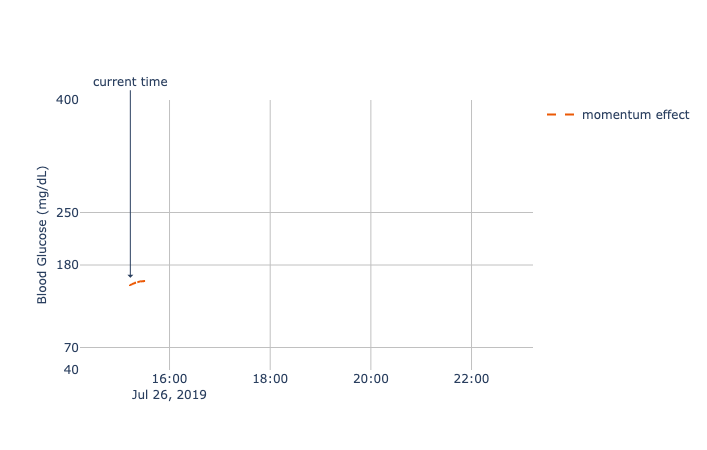

In [242]:
momentum_predicted_glucose_dates, momentum_predicted_glucose_values = predict_glucose(
    starting_date, starting_glucose,
    momentum_dates=recommendations.get("momentum_effect_dates"),
    momentum_values=recommendations.get("momentum_effect_values")
)

momentum_effect_trace = go.Scattergl(
    name="momentum effect",
    x=momentum_predicted_glucose_dates,
    y=momentum_predicted_glucose_values,
    hoverinfo="y+name",
    mode='lines',
    line=dict(
        color="#eb5905",
        dash="dash",
    )
)

fig = go.Figure(data=[momentum_effect_trace], layout=layout)
fig

## Retrospective Correction Effect

In [249]:
if recommendations.get("retrospective_effect_dates"):
    (retrospective_predicted_glucose_dates,
     retrospective_predicted_glucose_values
     ) = predict_glucose(
         starting_date, starting_glucose,
         correction_effect_dates=recommendations.get(
             "retrospective_effect_dates"
         ),
         correction_effect_values=recommendations.get(
             "retrospective_effect_values"
         )
         )

    rc_effect_trace = go.Scattergl(
        name="rc effect",
        x=retrospective_predicted_glucose_dates,
        y=retrospective_predicted_glucose_values,
        hoverinfo="y+name",
        mode='lines',
        line=dict(
            color="#4253ed",
            dash="dash",
        )
    )    
    fig = go.Figure(data=[rc_effect_trace], layout=layout)
    fig
    
else:
    (retrospective_predicted_glucose_dates,
     retrospective_predicted_glucose_values
     ) = ([], [])
    print("retrospective correction was NOT enabled")


retrospective correction was NOT enabled


# Visualize All Data

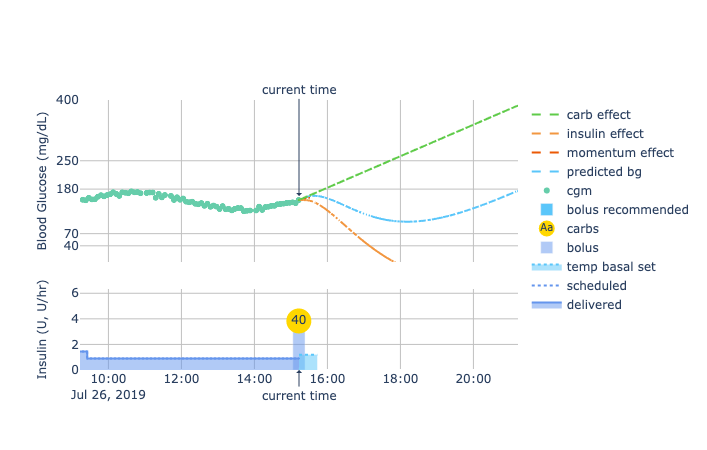

In [244]:
basal_trace.yaxis = "y"
sbr_trace.yaxis = "y"
recommended_basal_trace.yaxis = "y"
bolus_trace.yaxis = "y"
carb_trace.yaxis = "y"
recommended_bolus_trace.yaxis = "y"

bg_trace.yaxis = "y2"
bg_prediction_trace.yaxis = "y2"
momentum_effect_trace.yaxis = "y2"
insulin_effect_trace.yaxis = "y2"
carb_effect_trace.yaxis = "y2"
rc_effect_trace.yaxis = "y2"

data = [
    basal_trace, sbr_trace, recommended_basal_trace,
    bolus_trace, carb_trace, recommended_bolus_trace,
    bg_trace, bg_prediction_trace,
    momentum_effect_trace, insulin_effect_trace,
    carb_effect_trace, rc_effect_trace
]

layout = go.Layout(
    showlegend=True,
    plot_bgcolor="white",
    yaxis=dict(
        domain=[0, 0.3],
        range=[0, max(
            basal["sbr"].max() + 1,
            basal["tbr"].max() + 1,
            bolus["dose"].max() + 3,
            carbs["bolus_height"].max() + 3
        )],
        fixedrange=True,
        hoverformat=".2f",
        showgrid=True,
        gridcolor="#c0c0c0",
        title=dict(
            text="Insulin (U, U/hr)",
            font=dict(
                size=12
            )
        )
    ),
    yaxis2=dict(
        domain=[0.4, 1],
        range=[0, 400],
        tickvals=[-100, 40, 70, 180, 250, 400],
        fixedrange=True,
        hoverformat=".0f",
        zeroline=False,
        showgrid=True,
        gridcolor="#c0c0c0",
        title=dict(
            text="Blood Glucose (mg/dL)",
            font=dict(
                size=12
            )
        )
    ),
    xaxis=dict(
        range=(
            current_time - datetime.timedelta(hours=6),  
            current_time + datetime.timedelta(hours=6)
        ),
        showgrid=True,
        gridcolor="#c0c0c0",
    ),
    annotations=[
        go.layout.Annotation(
            x=current_time,
            y=bg["mg_dL"].values[-1] + 10,
            xref="x",
            yref="y2",
            text="current time",
            showarrow=True,
            arrowhead=1,
            ax=0,
            ayref="y2",
            ay=425
        ),
        go.layout.Annotation(
            x=current_time,
            y=0,
            xref="x",
            yref="y",
            text="current time",
            showarrow=True,
            arrowhead=1,
            ax=0,
            ayref="y",
            ay=-2
        )
    ],
    dragmode="pan",
    hovermode="x"
)

fig = go.Figure(data=data, layout=layout)
fig